# Monte Carlo in spinfoams

Description of the notebook

## Setup

In [1]:
# set Plot style
using Plots
using Plots.PlotMeasures
using LaTeXStrings

# set backend and style
pgfplotsx()
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    linewidth = 2,
    grid = :true,
    gridlinewidth = 0.5,
    markersize = 5,
    tickfontsize = 22,
    size = (900, 600),
    legendfontsize = 22,
    guidefontsize = 22,
    titlefontsize = 22,
    legend = (0.03, 0.98),
    foreground_color_axis = "black",
    foreground_color_border = "black",
    foreground_color_guide = "darkorange",
    foreground_color_text = "black",
    guidefontcolor = "black",
    plot_titlefontcolor = "black",
    titlefontcolor = "black",
    shape = [:circle],
    markershape = [:circle],
)

In [2]:
using CSV
using DataFrames

Simple Dict to remember how the float $\mu$ are represented in the data directory structure

In [3]:
MU = Dict([
    (0, 0.0), 
    (1, 1.0),
    (1/6, 0.167),
    (-1/6,-0.167)]) 

Dict{Real, Float64} with 4 entries:
  0         => 0.0
  -0.166667 => -0.167
  0.166667  => 0.167
  1         => 1.0

In [4]:
using Statistics

## Loading Data

Define the base paths where the data is stored

In [5]:
DIAGRAM = "self_energy";
BASE_DATA_DIRECTORY = "../../data";
MODEL = "BF";

Function to load a dataframe given the number of Monte Carlo sampling `Nmc`, the face weight $\mu$ `mu`, the boundary intertwiner `ib`, and the trial number `trial`

In [6]:
function get_data(Nmc, mu, ib, trial)
DataFrame(
            CSV.File(
                "$(BASE_DATA_DIRECTORY)/$(DIAGRAM)/jb_0.5/monte_carlo/Nmc_$(Nmc)/$(MODEL)/weight_$(mu)/ib_$(ib)/ampls_cutoff_10_trial_$(trial).csv",
            ),
        )
end


get_data (generic function with 1 method)

Function to load the dataframes for **ALL** the trials given the number of Monte Carlo sampling `Nmc`, the face weight $\mu$ `mu`, the boundary intertwiner `ib`

In [7]:
function get_data_alltrials(Nmc, mu, ib)
    amp_df = DataFrame()
    std_df = DataFrame()
    for trial in 1:10
        dftmp = get_data(Nmc,mu,ib,trial)
        amp_df[!,"trial$(trial)"] = dftmp.amp
        std_df[!,"trial$(trial)"] = dftmp.std
    end
    amp_df, std_df
end

get_data_alltrials (generic function with 1 method)

In [8]:
function get_data_exact(mu, ib)
DataFrame(
            CSV.File(
                "$(BASE_DATA_DIRECTORY)/$(DIAGRAM)/jb_0.5/exact/$(MODEL)/weight_$(mu)/ib_$(ib)/ampls_cutoff_10.csv",
            ),
        )
end

get_data_exact (generic function with 1 method)

## Error Analysis

We can easily compute the average and standard deviation of the amplitude over 10 trials 

In [9]:
amp_1K_1 , std_1K_1 = get_data_alltrials(1000,MU[1],0)

means_1K_1 = [mean(cutoff) for cutoff in eachrow(amp_1K_1)]
stds_1K_1 = [std(cutoff) for cutoff in eachrow(amp_1K_1)]
MCavgstds_1K_1 = [std(cutoff) for cutoff in eachrow(std_1K_1)]
stds_1K_1_P = 100*(stds_1K_1./means_1K_1)[2:end]
MCavgstds_1K_1_P = 100*(MCavgstds_1K_1./means_1K_1)[2:end]

amp_1K_1b , std_1K_1b = get_data_alltrials(1000,MU[0],1)

means_1K_1b = [mean(cutoff) for cutoff in eachrow(amp_1K_1b)]
stds_1K_1b = [std(cutoff) for cutoff in eachrow(amp_1K_1b)]
MCavgstds_1K_1b = [std(cutoff) for cutoff in eachrow(std_1K_1b)]
stds_1K_1_Pb = 100*(stds_1K_1b./means_1K_1b)[2:end]
MCavgstds_1K_1_Pb = 100*(MCavgstds_1K_1b./means_1K_1b)[2:end];

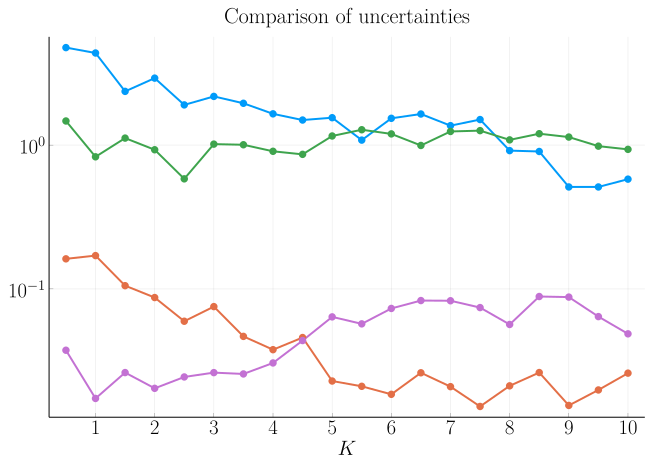

In [164]:

plotib0= plot(0.5:0.5:10,
               [stds_1K_1_P,
               MCavgstds_1K_1_P],
               yscale = :log10,
               label = ["std of averages" "average of MC error"],
               title = ["Comparison of uncertainties"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.6,0.9),
               )
plotib1= plot!(0.5:0.5:10,
               [stds_1K_1_Pb,
               MCavgstds_1K_1_Pb],
               yscale = :log10,
               xlabel = L"K",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = false
               )
# plot(plotib0,
#      plotib1,
#      layout=(2,1),
#      ylabel = "Error (%)",
#      )

In [11]:
amp_10K_1 , std_10K_1 = get_data_alltrials(10000,MU[1],0)

means_10K_1 = [mean(cutoff) for cutoff in eachrow(amp_10K_1)]
stds_10K_1 = [std(cutoff) for cutoff in eachrow(amp_10K_1)]
MCavgstds_10K_1 = [std(cutoff) for cutoff in eachrow(std_10K_1)]
stds_10K_1_P = 100*(stds_10K_1./means_10K_1)[2:end]
MCavgstds_10K_1_P = 100*(MCavgstds_10K_1./means_10K_1)[2:end]

amp_10K_1b , std_10K_1b = get_data_alltrials(10000,MU[0],1)

means_10K_1b = [mean(cutoff) for cutoff in eachrow(amp_10K_1b)]
stds_10K_1b = [std(cutoff) for cutoff in eachrow(amp_10K_1b)]
MCavgstds_10K_1b = [std(cutoff) for cutoff in eachrow(std_10K_1b)]
stds_10K_1_Pb = 100*(stds_10K_1b./means_10K_1b)[2:end]
MCavgstds_10K_1_Pb = 100*(MCavgstds_10K_1b./means_10K_1b)[2:end];

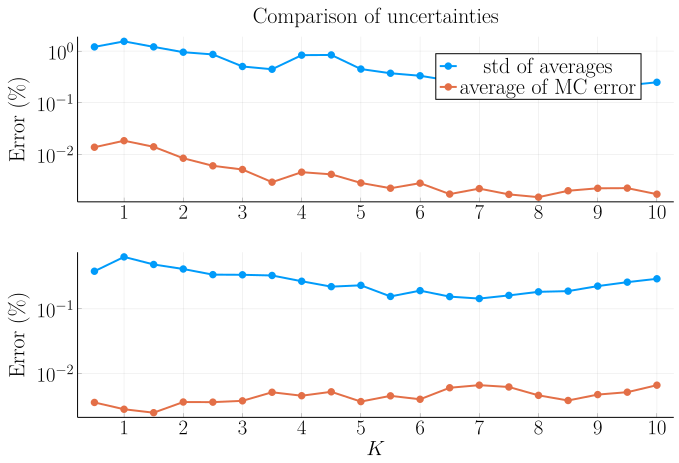

In [12]:
plotib0= plot(0.5:0.5:10,
               [stds_10K_1_P,
               MCavgstds_10K_1_P],
               yscale = :log10,
               label = ["std of averages" "average of MC error"],
               title = ["Comparison of uncertainties"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.6,0.9),
               )
plotib1= plot(0.5:0.5:10,
               [stds_10K_1_Pb,
               MCavgstds_10K_1_Pb],
               yscale = :log10,
               xlabel = L"K",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = false
               )
plot(plotib0,
     plotib1,
     layout=(2,1),
     ylabel = "Error (%)",
     )

In [13]:
amp_100K_1 , std_100K_1 = get_data_alltrials(100000,MU[1],0)

means_100K_1 = [mean(cutoff) for cutoff in eachrow(amp_100K_1)]
stds_100K_1 = [std(cutoff) for cutoff in eachrow(amp_100K_1)]
MCavgstds_100K_1 = [std(cutoff) for cutoff in eachrow(std_100K_1)]
stds_100K_1_P = 100*(stds_100K_1./means_100K_1)[2:end]
MCavgstds_100K_1_P = 100*(MCavgstds_100K_1./means_100K_1)[2:end]

amp_100K_1b , std_100K_1b = get_data_alltrials(100000,MU[0],1)

means_100K_1b = [mean(cutoff) for cutoff in eachrow(amp_100K_1b)]
stds_100K_1b = [std(cutoff) for cutoff in eachrow(amp_100K_1b)]
MCavgstds_100K_1b = [std(cutoff) for cutoff in eachrow(std_100K_1b)]
stds_100K_1_Pb = 100*(stds_100K_1b./means_100K_1b)[2:end]
MCavgstds_100K_1_Pb = 100*(MCavgstds_100K_1b./means_100K_1b)[2:end];

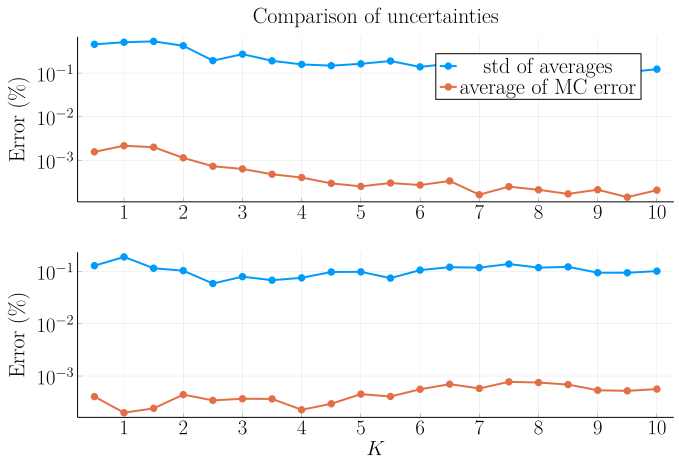

In [14]:

plotib0= plot(0.5:0.5:10,
               [stds_100K_1_P,
               MCavgstds_100K_1_P],
               yscale = :log10,
               label = ["std of averages" "average of MC error"],
               title = ["Comparison of uncertainties"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.6,0.9),
               )
plotib1= plot(0.5:0.5:10,
               [stds_100K_1_Pb,
               MCavgstds_100K_1_Pb],
               yscale = :log10,
               xlabel = L"K",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = false
               )
plot(plotib0,
     plotib1,
     layout=(2,1),
     ylabel = "Error (%)",
     )

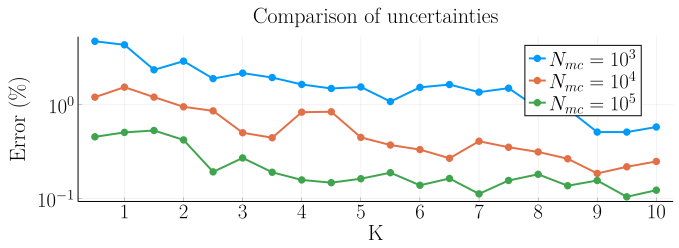

In [15]:

plot_ib0_Nmc= plot(0.5:0.5:10,
               [stds_1K_1_P,
                stds_10K_1_P,
                stds_100K_1_P],
               yscale = :log10,
               label = [L"$N_{mc}=10^3$" L"$N_{mc}=10^4$" L"$N_{mc}=10^5$"],
               #label = ["1K" "10K" "100K"],
               title = ["Comparison of uncertainties"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.75,0.95),
               size = (900, 300),
               ylabel = "Error (%)",
               xlabel = "K",
               )


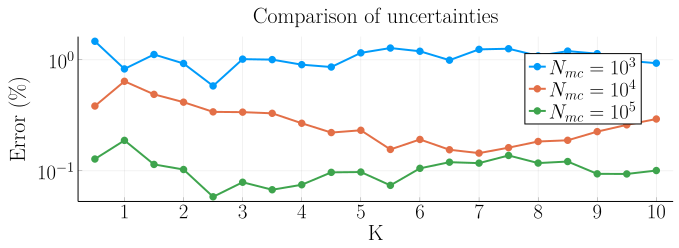

In [16]:
plot_ib1_Nmc= plot(0.5:0.5:10,
               [stds_1K_1_Pb,
                stds_10K_1_Pb,
                stds_100K_1_Pb],
               yscale = :log10,
               label = [L"$N_{mc}=10^3$" L"$N_{mc}=10^4$" L"$N_{mc}=10^5$"],
               #label = ["1K" "10K" "100K"],
               title = ["Comparison of uncertainties"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               yticks = [1, 0.1],
               legend = (0.75,0.9),
               size = (900, 300),
               ylabel = "Error (%)",
               xlabel = "K",
               )

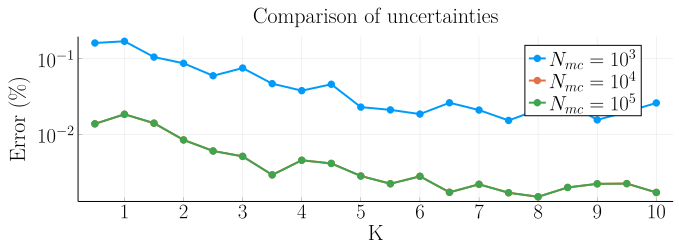

In [17]:

plot_ib0_Nmc= plot(0.5:0.5:10,
               [MCavgstds_1K_1_P,
                MCavgstds_10K_1_P,
                MCavgstds_10K_1_P],
               yscale = :log10,
               label = [L"$N_{mc}=10^3$" L"$N_{mc}=10^4$" L"$N_{mc}=10^5$"],
               #label = ["1K" "10K" "100K"],
               title = ["Comparison of uncertainties"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.75,0.95),
               size = (900, 300),
               ylabel = "Error (%)",
               xlabel = "K",
               )

In [18]:
exact_melon_1 = get_data_exact(MU[1],0).amp;
exact_melon_1b = get_data_exact(MU[1],1).amp;

In [22]:
difference_means_exact_1K = ((means_1K_1./exact_melon_1).-1)[2:end];
std_exact_1K = ((stds_1K_1./exact_melon_1))[2:end];

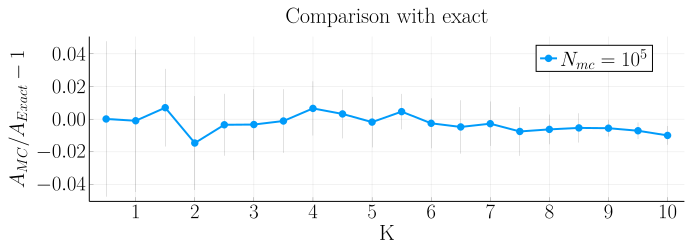

In [25]:
plot(0.5:0.5:10,
               [difference_means_exact_1K],
               label = [L"$N_{mc}=10^3$"],
               #label = ["1K" "10K" "100K"],
               title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.75,0.95),
               size = (900, 300),
               ylabel = [L"A_{MC}/A_{Exact} -1"],
               xlabel = "K",
               yerror= std_exact_1K,
               )
#
#hline!([0])

In [26]:
difference_means_exact_10K = ((means_10K_1./exact_melon_1).-1)[2:end];
std_exact_10K = ((stds_10K_1./exact_melon_1))[2:end];

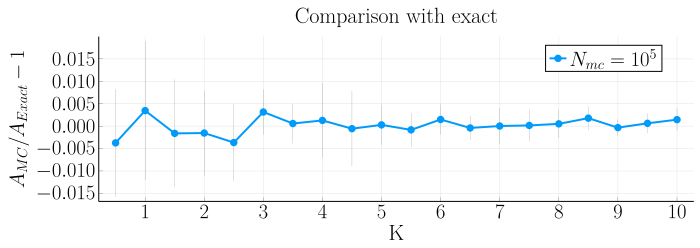

In [27]:
plot(0.5:0.5:10,
               [difference_means_exact_10K],
               label = [L"$N_{mc}=10^4$"],
               #label = ["1K" "10K" "100K"],
               title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.75,0.95),
               size = (900, 300),
               ylabel = [L"A_{MC}/A_{Exact} -1"],
               xlabel = "K",
               yerror= std_exact_10K,
               )
#
#hline!([0])

In [28]:
difference_means_exact_100K = ((means_100K_1./exact_melon_1).-1)[2:end];
std_exact_100K = ((stds_100K_1./exact_melon_1))[2:end];

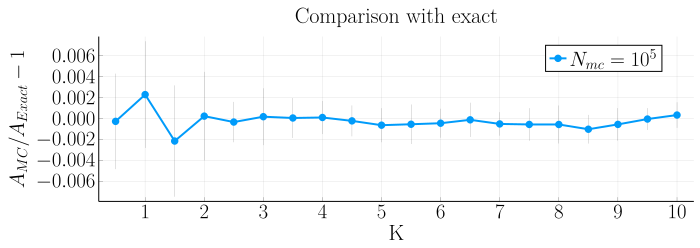

In [29]:
plot_ib0_Nmc= plot(0.5:0.5:10,
               [difference_means_exact_100K],
               label = [L"$N_{mc}=10^5$"],
               #label = ["1K" "10K" "100K"],
               title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.75,0.95),
               size = (900, 300),
               ylabel = [L"A_{MC}/A_{Exact} -1"],
               xlabel = "K",
               yerror= std_exact_100K,
               )
#
#hline!([0])

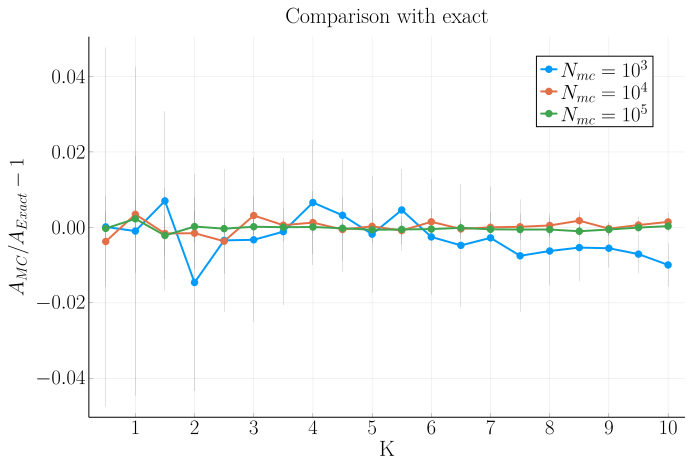

In [32]:
plot(0.5:0.5:10,
               [difference_means_exact_1K],
               label = [L"$N_{mc}=10^3$"],
               #label = ["1K" "10K" "100K"],
               title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.75,0.95),
               ylabel = [L"A_{MC}/A_{Exact} -1"],
               xlabel = "K",
               yerror= std_exact_1K,
               )
               
plot!(0.5:0.5:10,
               [difference_means_exact_10K],
               label = [L"$N_{mc}=10^4$"],
               #label = ["1K" "10K" "100K"],
               title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.75,0.95),
               ylabel = [L"A_{MC}/A_{Exact} -1"],
               xlabel = "K",
               yerror= std_exact_10K,
               )
plot!(0.5:0.5:10,
               [difference_means_exact_100K],
               label = [L"$N_{mc}=10^5$"],
               #label = ["1K" "10K" "100K"],
               title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.75,0.95),
               ylabel = [L"A_{MC}/A_{Exact} -1"],
               xlabel = "K",
               yerror= std_exact_100K,
               )

## Examples of estimating the scaling of the Divergence

We use the simplest possible fit Least Squares fit

In [146]:
using LsqFit

We always fit with a function 
$$ c_2 K^{c_1} + c_3 K^{c_1-1} $$
note that this should capture the scaling only qualitatively. The full amplitude would behave as a general polynomial of order $c_1$. However adding too many terms would for sure overfit the data. Not enough terms will underfit the data failing to capture the complexity of the scaling.  

In [149]:
function fit_scaling(data, scalingseed = 1.0)
    # Def of the model. The @. make it such it apply to the array term by term
    @. model(K, c) = c[2] * K^c[1] + c[3] * K^(c[1]-1)
    # general range for which we have the data
    cutoffs = 0:0.5:10
    # initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
    c0 = [scalingseed,1.0,1.0]
    # We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
    curve_fit(model, cutoffs[9:end], data[9:end], c0)
end

fit_scaling (generic function with 2 methods)

Let's fit the amplitude with $\mu = 1$ we know it should diverge as $K^9$. We start with the exact calculation.

In [150]:
 exact_melon_1 = get_data_exact(MU[1],0).amp;

In [151]:
fit = fit_scaling(exact_melon_1)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([8.699945298596635, 7.361710921504718, 40.584494962075894], [-558483.7914084005, -1.0208385568759199e6, -1.5655719646917172e6, -2.356572765374899e6, -2.9359918624360263e6, -3.6574692168930173e6, -3.4032523364852667e6, -3.170534293769002e6, -918011.694981575, 502369.88592004776, 3.9622116856245995e6, 2.0950611792902946e6, -2.374862997994423e6], [4.1973664298849115e6 172937.4261486778 43234.356538317224; 1.1871624411994133e7 481851.41448990355 107078.0921083285; … ; 8.400282401767676e9 3.207316977564606e8 3.3761231343625106e7; 1.3177505094809685e10 5.011241107482563e8 5.011241107613585e7], false, Float64[])

With CI 95% the scaling parameter has a HUGE compatible interval

In [152]:
confidence_interval(fit)

3-element Vector{Tuple{Float64, Float64}}:
 (7.432316076997333, 9.967574520195937)
 (-28.250696911061176, 42.97411875407061)
 (17.693799298312186, 63.4751906258396)

We interpret this as a sign of the fact that the LO and NLO of the divergence have contributes in a very similar way in the range of values we are considering for the function. Therefore it is very difficult for the numerical fit to distinguish among them. Making very hard to find the scaling exponent.  

This is also confirmed by the Huge convariance of the two coefficients.

In [153]:
estimate_covar(fit)

3×3 Matrix{Float64}:
  0.323668    -9.09293     5.82887
 -9.09293    255.457    -163.812
  5.82887   -163.812     105.544

If this numerical fit does not work with the exact data, there is no reason for it to work with the MC data. As a consistency check:

In [154]:
amp_100K_1 , std_100K_1 = get_data_alltrials(100000,MU[1],0);
means_100K_1 = [mean(cutoff) for cutoff in eachrow(amp_100K_1)];

In [155]:
fit = fit_scaling(means_100K_1)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([8.721505839882433, 6.844210382086334, 40.2609676894203], [-573603.4745070692, -1.052060987762183e6, -1.6205019794132635e6, -2.460231849594757e6, -3.118660564190522e6, -3.9956433668468595e6, -3.790333091546476e6, -3.6293386377506256e6, -1.3706466700280905e6, 950030.0220806599, 4.407830622280598e6, 2.155149156000614e6, -2.567915885451317e6], [4.176906257561658e6 178184.42105639866 44546.10526469668; 1.1821677434640534e7 497733.3643131744 110607.41429426838; … ; 8.400017304469177e9 3.366837326271866e8 3.54403929091961e7; 1.3181454816986254e10 5.266302963560561e8 5.266302963516997e7], false, Float64[])

In [156]:
confidence_interval(fit)

3-element Vector{Tuple{Float64, Float64}}:
 (7.090453633506936, 10.35255804625793)
 (-36.21234415522208, 49.90076491939474)
 (17.83280782061338, 62.68912755822721)

In [157]:
estimate_covar(fit)

3×3 Matrix{Float64}:
   0.53586   -14.1455     7.34538
 -14.1455    373.417   -193.967
   7.34538  -193.967    101.322

We find exactly the same issue.

As a solution we propose to change. The face weight $\mu =1 \to 0$. In this way the divergence $K^9 \to K^3$ and we expect a larger difference between the LO and NLO coefficients

In [159]:
amp_100K_0 , std_100K_0 = get_data_alltrials(100000,MU[0],0);
means_100K_0 = [mean(cutoff) for cutoff in eachrow(amp_100K_0)];

In [160]:
fit = fit_scaling(means_100K_0)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([2.974943194488124, 1.9879157859028553, 3.5360553301846522], [0.15934578293197887, 0.006324690369041264, 0.07272844254043775, -0.02560130158173024, -0.10454839789940706, -0.07256358844995248, -0.07738585636957396, -0.13370633697877565, 0.0260703456540341, 0.0857733152356559, 0.31512387985685564, -0.08529067503513943, -0.11276090512410519], [246.10674880458635 61.81505697514567 15.453764243791971; 366.1008280310289 87.75464676447773 19.5010326144921; … ; 4305.665562105963 810.3491588289107 85.29991145713848; 5089.287666417468 943.937401653462 94.39374016690729], true, Float64[])

In [161]:
confidence_interval(fit)

3-element Vector{Tuple{Float64, Float64}}:
 (2.9681654959585777, 2.98172089301767)
 (1.9437360205940837, 2.032095551211627)
 (3.45771431584621, 3.6143963445230947)

In [162]:
estimate_covar(fit)

3×3 Matrix{Float64}:
  9.25295e-6   -6.02946e-5    0.000106107
 -6.02946e-5    0.000393154  -0.000693637
  0.000106107  -0.000693637   0.00123621

Notice how the fit works way better! We cannot expect to get exactly 3 as the LO scaling coefficient since we are ignoring the NNLO and so on.

# Matplotlib test

In [6]:
using Plots
pyplot()
Plots.pyrcparams["text.usetex"] = true

true

In [39]:
default(
    grid = :true,
    gridlinewidth = 0.5,
    tickfontsize = 22,
    legendfontsize = 22,
    guidefontsize = 22,
    titlefontsize = 22,
    framestyle=:box,
    legend=false,
    size = (900, 600),
)

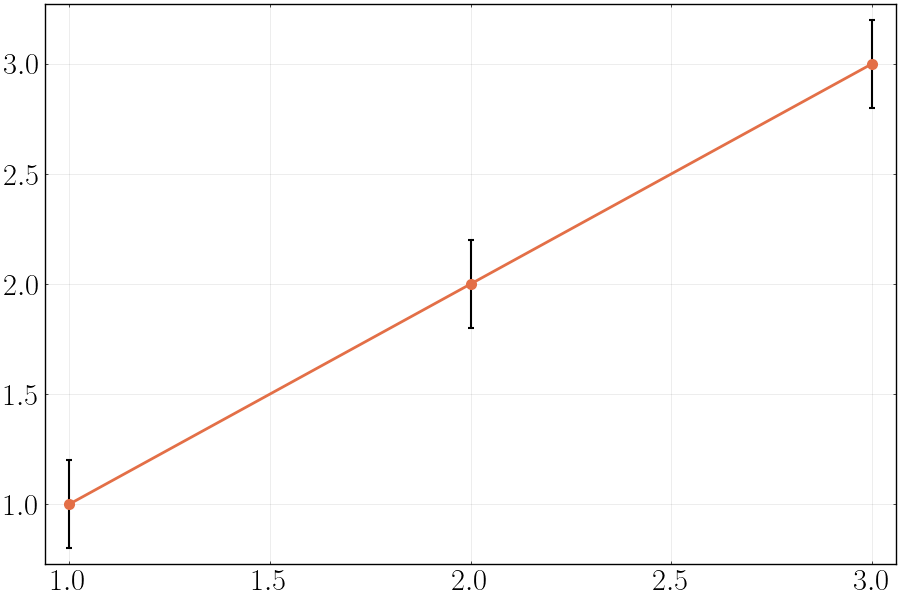

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [42]:
plot([1,2,3],[1,2,3],line=false,marker=false,yerror=[0.2,0.2,0.2],markerstrokewidth=1.5)
plot!([1,2,3],[1,2,3],line=2,marker=:circle,markerstrokewidth=0, markersize = 8,linewidth = 2,)